# Sparkify 流失用户分析
Sparkify是一个国外的音乐平台，本文将介绍预测Sparkify流失用户的过程。我们使用的数据是Sparkify的用户使用log，其中包含用户听的歌曲，时长，艺术家，访问页面，注册时间，地区等等数据，完整的数据集有12G，但因本文是使用单节点Spark来进行数据分析和建模的实验，为了加快速度仅使用其中一部分128M的数据。

In [1]:
# 加载所拥到的库
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, sum as Fsum, current_date,\
from_unixtime, datediff, current_date, countDistinct, month, substring, count, when, isnull
from pyspark.sql.types import IntegerType, StringType, FloatType, DateType, Row

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer,PCA, RegexTokenizer, StandardScaler, StopWordsRemover,\
StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.linalg import DenseVector, SparseVector

import re
import seaborn as sns
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# create a Spark session
spark = SparkSession.builder.master("local").appName("Spark Project").getOrCreate()

# 加载和清洗数据 

In [3]:
data_path = "mini_sparkify_event_data.json"

In [4]:
df = spark.read.json(data_path)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

查看数据集

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# 查看访问页面的种类
df.select("page").distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



查看各个特征值的缺失值

In [7]:
df.select([(count(when(isnull(c), c))/df.count()).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0-----------------------------
 artist        | 0.20381151832460734  
 auth          | 0.0                  
 firstName     | 0.029130890052356022 
 gender        | 0.029130890052356022 
 itemInSession | 0.0                  
 lastName      | 0.029130890052356022 
 length        | 0.20381151832460734  
 level         | 0.0                  
 location      | 0.029130890052356022 
 method        | 0.0                  
 page          | 0.0                  
 registration  | 0.029130890052356022 
 sessionId     | 0.0                  
 song          | 0.20381151832460734  
 status        | 0.0                  
 ts            | 0.0                  
 userAgent     | 0.029130890052356022 
 userId        | 0.0                  



可以发现firstName,gender,userId等缺失比例相同，我猜测缺失的是同一批数据

In [8]:
# 查看firstName缺失值
df.where(col('firstName').isNull()).show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

将userId为空的数据删除，并再次查看缺失值情况。

In [9]:
df = df.filter("userId != ''")
df.select([(count(when(isnull(c), c))/df.count()).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0----------------------------
 artist        | 0.17992191376000344 
 auth          | 0.0                 
 firstName     | 0.0                 
 gender        | 0.0                 
 itemInSession | 0.0                 
 lastName      | 0.0                 
 length        | 0.17992191376000344 
 level         | 0.0                 
 location      | 0.0                 
 method        | 0.0                 
 page          | 0.0                 
 registration  | 0.0                 
 sessionId     | 0.0                 
 song          | 0.17992191376000344 
 status        | 0.0                 
 ts            | 0.0                 
 userAgent     | 0.0                 
 userId        | 0.0                 



In [10]:
df.count()

278154

另外我们发现ts,registration数据类型是timestamp，我们需要将其转换成DateType

In [11]:
# 将ts,registration转化为datetype
df = df.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))

df = df.withColumn("reg_date",from_unixtime(col('registration')/1000).cast(DateType()))

df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- date: date (nullable = true)
 |-- reg_date: date (nullable = true)



# 探索性数据分析

### 定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。

### 探索数据
你定义好客户流失后，执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

### 提出问题
- 流失用户与用户性别，付费情况，注册时长，地区，设备，平均每天Session数，平均ItemInSession的关系
- 流失用户与访问特定页面数量时间的关系

In [12]:
# 定义流失用户
flag_cancel_confirmation = udf(lambda x : 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("cancelled", flag_cancel_confirmation("page"))

windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding,0)

df = df.withColumn("churn",Fsum("cancelled").over(windowval))

1 查看流失用户与性别的关系

In [13]:
gender = df.dropDuplicates(["userId","gender"]).groupby(["churn","gender"]).count().toPandas()

Text(0.5,1,'churn_gender')

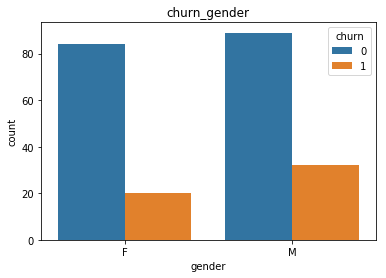

In [14]:
sns.barplot(x="gender", y="count", hue="churn",data=gender).set_title("churn_gender")

- 总量流失使用中男性多于女性，但差别不大

2 查看付费用户与免费用户中流失用户数量的差别

Text(0.5,1,'churn_level')

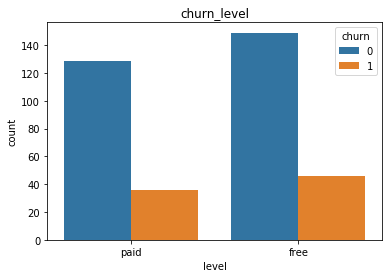

In [15]:
gender = df.dropDuplicates(["userId","level"]).groupby(["churn","level"]).count().toPandas()
sns.barplot(x="level", y="count", hue="churn",data=gender).set_title("churn_level")

- 付费用户与免费用户流失比例相差不大

3 查看注销与否和注册时长的关系

In [16]:
reg_time = df.groupBy("userId","churn").agg({"date":"max","reg_date":"max"})\
.withColumnRenamed("max(date)", "max_date").withColumnRenamed("max(reg_date)", "reg")
reg_time = reg_time.withColumn("reg_time",datediff(col("max_date"),col("reg")))
reg_time_df = reg_time.toPandas()
df = df.join(reg_time, on = ['userId','churn'])

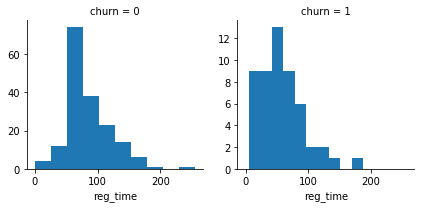

In [17]:
g = sns.FacetGrid(reg_time_df, col="churn", sharey=False)
g.map(plt.hist, "reg_time")

4 查看itemInSession与是否注销的关系

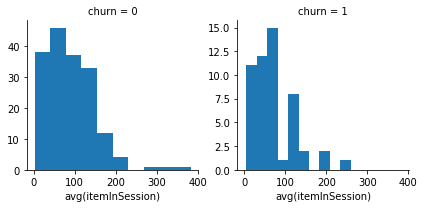

In [18]:
itemInSession_df = df.groupBy(['userId','churn']).avg('itemInSession').toPandas()
g = sns.FacetGrid(itemInSession_df, col="churn", sharey=False)
g.map(plt.hist, "avg(itemInSession)")

- 由于数据的量比较小，分布差别不大

5 查看地区与注销与否的关系

In [19]:
df = df.withColumn('state',substring(col('location'), -2, 3))

df.groupBy(['churn','state']).count().where(df['churn']==0).sort(col('count').desc()).show(5)
df.groupBy(['churn','state']).count().where(df['churn']==1).sort(col('count').desc()).show(5)

+-----+-----+-----+
|churn|state|count|
+-----+-----+-----+
|    0|   CA|39158|
|    0|   PA|23708|
|    0|   TX|22200|
|    0|   NH|18637|
|    0|   FL|11427|
+-----+-----+-----+
only showing top 5 rows

+-----+-----+-----+
|churn|state|count|
+-----+-----+-----+
|    1|   CA| 7613|
|    1|   CO| 4317|
|    1|   MS| 3839|
|    1|   WA| 3526|
|    1|   OH| 3173|
+-----+-----+-----+
only showing top 5 rows



In [20]:
print(df.select('state').distinct().count())
print(df.select('userId').distinct().count())

39
225


- 一共225个用户，地区就有39个，参考意义不大

6 查看userAgent与用户是否注销的关系


In [21]:
find_user_agent = udf(lambda x : re.findall(r"Mozilla/5.0 \((.+?) ",x),StringType())
df = df.withColumn('new_ua',find_user_agent('userAgent'))

In [22]:
df.filter('churn = 1').groupby('new_ua').count().sort(col('count').desc()).show()

+------------+-----+
|      new_ua|count|
+------------+-----+
|   [Windows]|24737|
|[Macintosh;]|17355|
|      [X11;]| 1762|
|   [iPhone;]| 1010|
+------------+-----+



In [23]:
df.filter('churn = 0').groupby('new_ua').count().sort(col('count').desc()).show()

+-------------+------+
|       new_ua| count|
+-------------+------+
|    [Windows]|108450|
| [Macintosh;]| 85394|
|      [iPad;]| 11381|
|[compatible;]| 10684|
|    [iPhone;]| 10182|
|       [X11;]|  7199|
+-------------+------+



Text(0,0.5,'The number of user')

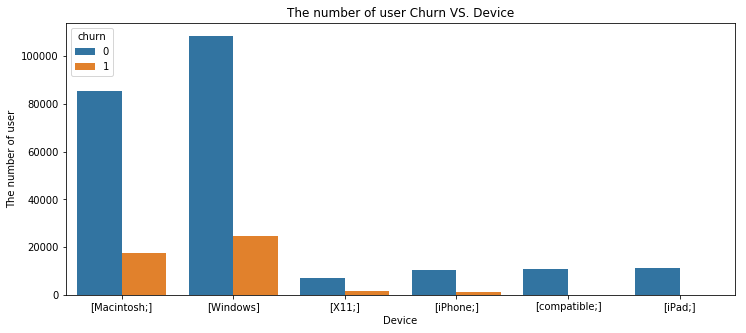

In [24]:
plt.figure(figsize=(12, 5))
sns.countplot(x = "new_ua", hue = "churn",
              data=df.toPandas())
plt.title("The number of user Churn VS. Device")
plt.xlabel("Device")
plt.ylabel("The number of user")

7 查看流失用户与访问次数的关系

In [25]:
df = df.withColumn('month',month('date'))
# 计算每天的访问次数
day_df = df.groupBy(['userId','churn','date']).agg(countDistinct('sessionId')).groupBy('userId','churn')\
.avg('count(DISTINCT sessionId)').withColumnRenamed('avg(count(DISTINCT sessionId))','daily_session')
df = df.join(day_df, on=['userId','churn'])

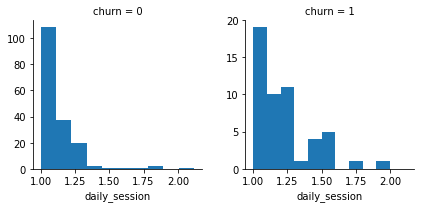

In [26]:
g = sns.FacetGrid(day_df.toPandas(), col="churn", sharey=False)
g.map(plt.hist, "daily_session");

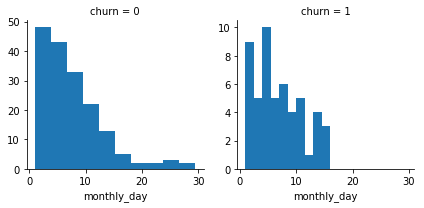

In [27]:
# 计算每个月的平均访问天数
month_df = df.groupBy(['userId','churn','month']).agg(countDistinct('date')).groupBy('userId','churn')\
.avg('count(DISTINCT date)').withColumnRenamed('avg(count(DISTINCT date))','monthly_day')
df = df.join(month_df, on=['userId','churn'])
g = sns.FacetGrid(month_df.toPandas(), col="churn", sharey=False)
g.map(plt.hist, "monthly_day")

8 查看用户流失与各页面访问次数的关系

In [28]:
# 统计各个page的访问数量
for p in ['Downgrade','Roll Advert','Thumbs Down','Add to Playlist','Add Friend','Thumbs Up','NextSong','Upgrade']:
    df = df.withColumn(p, (df['page']==p).cast(IntegerType()))

page_df = df.groupBy('userId','churn').agg({'Downgrade':'sum',
                                    'Upgrade':'sum',
                                   'Roll Advert':'sum',
                                   'Thumbs Down':'sum',
                                   'Add to Playlist':'sum',
                                   'Add Friend':'sum',
                                   'Thumbs Up':'sum',
                                    'NextSong':'sum'}).toPandas()

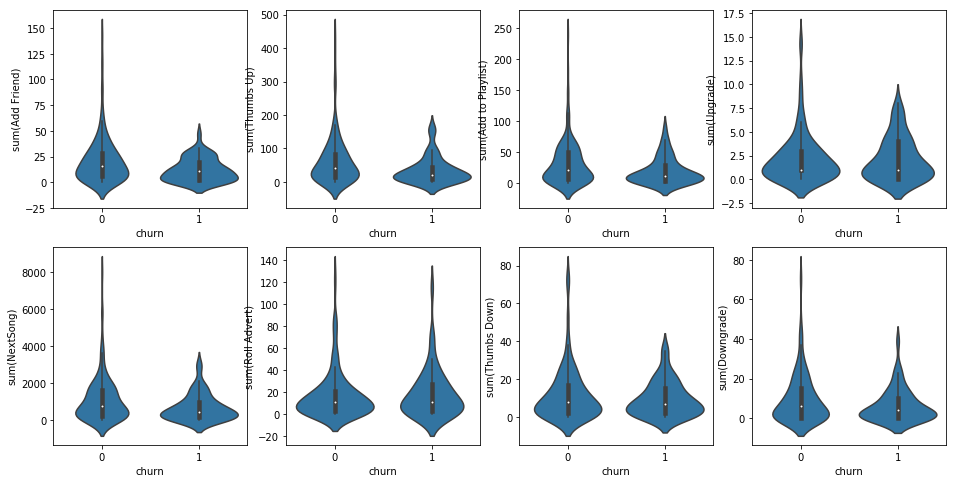

In [29]:
plt.figure(figsize=(16,8))
plt.subplot(241)
sns.violinplot(data=page_df, x = "churn", y = "sum(Add Friend)", \
               color = sns.color_palette()[0])

plt.subplot(242)
sns.violinplot(data=page_df, x = "churn", y = "sum(Thumbs Up)", \
               color = sns.color_palette()[0])

plt.subplot(243)
sns.violinplot(data=page_df, x = "churn", y = "sum(Add to Playlist)", \
               color = sns.color_palette()[0])

plt.subplot(244)
sns.violinplot(data=page_df, x = "churn", y = "sum(Upgrade)", \
               color = sns.color_palette()[0])

plt.subplot(245)
sns.violinplot(data=page_df, x = "churn", y = "sum(NextSong)", \
               color = sns.color_palette()[0])

plt.subplot(246)
sns.violinplot(data=page_df, x= "churn", y = "sum(Roll Advert)", \
               color = sns.color_palette()[0])

plt.subplot(247)
sns.violinplot(data=page_df, x = "churn", y = "sum(Thumbs Down)", \
               color = sns.color_palette()[0])

plt.subplot(248)
sns.violinplot(data=page_df, x = "churn", y = "sum(Downgrade)", \
               color = sns.color_palette()[0]);

# 特征工程  
我决定使用以下特征值  
- 注册天数
- 每天访问次数
- 每月访问天数
- 注册天数
- 付费与否
- 页面访问次数  
 - 升级页面
 - 降级页面
 - 广告页面
 - 踩
 - 点赞
 - 加好友
 - 添加到播放列表
 - 下一首歌

In [30]:
features = df.groupBy('userId').agg({'itemInSession':'avg',
                                   'daily_session':'min',
                                   'monthly_day':'min',
                                   'reg_time':'min',
                                   'level':'max',
                                   'churn':'max',
                                   'Downgrade':'sum',
                                   'Roll Advert':'sum',
                                   'Thumbs Down':'sum',
                                   'Add to Playlist':'sum',
                                   'Add Friend':'sum',
                                   'Thumbs Up':'sum',
                                    'Upgrade':'sum',
                                    'NextSong':'sum'})
                                   

features = features.select(col('avg(itemInSession)').alias('itemInSession'),
                                 col('min(daily_session)').alias('daily_session'),
                                 col('min(monthly_day)').alias('monthly_day'),
                                 col('min(reg_time)').alias('days_since_reg'),
                  col('max(level)').alias('level'),
                  col('sum(Downgrade)').alias('downgrade'),
                  col('sum(Roll Advert)').alias('rollAdvert'),
                  col('sum(Thumbs Down)').alias('thumbsDown'),
                  col('sum(Add to Playlist)').alias('addToPlaylist'),
                  col('sum(Add Friend)').alias('addFriend'),
                  col('sum(Thumbs Up)').alias('thumbsUp'),
                  col('sum(Upgrade)').alias('upgrade'),
                  col('sum(NextSong)').alias('nextSong'),
                  col('max(churn)').alias('label'))

In [31]:
# 查看有没有空值
features.select([count(when(isnull(c), c)).alias(c) for c in features.columns]).show()

+-------------+-------------+-----------+--------------+-----+---------+----------+----------+-------------+---------+--------+-------+--------+-----+
|itemInSession|daily_session|monthly_day|days_since_reg|level|downgrade|rollAdvert|thumbsDown|addToPlaylist|addFriend|thumbsUp|upgrade|nextSong|label|
+-------------+-------------+-----------+--------------+-----+---------+----------+----------+-------------+---------+--------+-------+--------+-----+
|            0|            0|          0|             0|    0|        0|         0|         0|            0|        0|       0|      0|       0|    0|
+-------------+-------------+-----------+--------------+-----+---------+----------+----------+-------------+---------+--------+-------+--------+-----+



In [32]:
indexer_level = StringIndexer(inputCol='level', outputCol='level_index')
# 将各个特征整合成向量
assembler = VectorAssembler(inputCols=['daily_session',
                                      'monthly_day',
                                      'days_since_reg',
                                      'level_index',
                                      'downgrade',
                                      'rollAdvert',
                                      'thumbsDown',
                                      'addToPlaylist',
                                      'addFriend',
                                      'thumbsUp',
                                      'nextSong',
                                      'upgrade'], outputCol='NumFeatures')
# 使用
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features")
#scaler = MinMaxScaler(inputCol="NumFeatures", outputCol="features")

features_pipeline = Pipeline(stages=[indexer_level, assembler, scaler])

model_df = features_pipeline.fit(features).transform(features)

In [33]:
# 将稀疏向量转成稠密向量
model_df_clean = model_df.select(['label','features'])
df2 = model_df.select("label", "features")
rdd = df2.rdd.map(lambda x: Row(label=x[0],features=DenseVector(x[1].toArray()))
                     if (len(x)>1 and hasattr(x[1], "toArray"))
                     else Row(label=None, features=DenseVector([])))
model_data = spark.createDataFrame(rdd)

# 建模
将完整数据集分成训练集、测试集和验证集。测试几种机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，为了防止模型预测全员没有流失而也到高分，我建议选用 F1 score 作为优化指标。

In [34]:
# 分割训练集和测试集
train, test = model_data.randomSplit([0.9, 0.1], seed=42)

In [35]:
def cal_f1_score(train,test,model):
    start_time = time.time()
    result = model.fit(train)
    prediction = result.transform(test)
    end_time = time.time()
    
    f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    f1_score = f1_score_evaluator.evaluate(prediction.select(col('label'), col('prediction')))
    print('Run Time is {}'.format(np.round(((end_time - start_time)/60),2)))
    print('The F1-Score is {}'.format(f1_score))

In [41]:
# 逻辑回归
model = LogisticRegression()
cal_f1_score(train,test,model)

# 随机森林
model = RandomForestClassifier(seed = 42)
cal_f1_score(train,test,model)

# 集成方法
model = GBTClassifier(seed = 42)
cal_f1_score(train,test,model)

Run Time is 2.79
The F1-Score is 0.6858974358974359
Run Time is 1.2
The F1-Score is 0.7835714285714286
Run Time is 5.0
The F1-Score is 0.6392857142857143


从上面结果得到随机森林的训练用时最短且效果最好，下一步我们来调整随机森林的超参数。  
maxDepth可能取值有5，10  
numTrees可能取值有20，50  
我们选用多组参数，进行交叉验证，选择表现好的参数。

In [37]:
classifier = RandomForestClassifier(seed = 42)
paramGrid = ParamGridBuilder()\
        .addGrid(classifier.maxDepth, [5, 10])\
        .addGrid(classifier.numTrees, [20, 50])\
        .build()

crossval = CrossValidator(estimator = Pipeline(stages=[classifier]),
                         estimatorParamMaps = paramGrid,
                         evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                         numFolds = 3)

classification = crossval.fit(train)
results = classification.transform(test)

# 计算准确率和f1分数
accuracy_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
accuracy = accuracy_evaluator.evaluate(results.select(col('label'), col('prediction')))

f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
f1_score = f1_score_evaluator.evaluate(results.select(col('label'), col('prediction')))

print('The accuracy on the test set is {:.2%} and the F-1 score is {}'\
.format(accuracy, f1_score))

The accuracy on the test set is 81.25% and the F-1 score is 0.7835714285714286


In [38]:
# 查看特征重要性
DenseVector(classification.bestModel.stages[-1].featureImportances)

DenseVector([0.1231, 0.073, 0.2542, 0.0022, 0.0393, 0.0953, 0.0896, 0.0671, 0.0789, 0.0726, 0.0629, 0.0418])

In [39]:
# 查看最佳参数
classification.getEstimatorParamMaps()[np.argmax(classification.avgMetrics)]

{Param(parent='RandomForestClassifier_a6bc79c16497', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10,
 Param(parent='RandomForestClassifier_a6bc79c16497', name='numTrees', doc='Number of trees to train (>= 1).'): 50}

##### 评估得分
- 准确度81.25%
- F-1 score:0.7836

##### 最佳参数
- maxDepth 10
- numTrees 50

##### 主要特征
- 注册天数
- 平均每天访问次数

# 总结
- 本次由于数据集较小可能会导致测试集上的预测准确率很难提升
- 尝试了逻辑回归模型，随机森林和集成方法，其中随机森林模型的训练用时最短效果最好
- 一开始使用MinMaxScaler进行转换，结果一些较小的值都被转换为0，导致预测精度下降
- 本次项目是根据截至当前的用户行为数据来预测用户是否注销，但是实际上工作中肯定预测的是未来一段时间用户是否注销。
- 本次使用的特征以外，细想一下还有很多特征值得尝试，譬如喜欢的音乐家数量，听歌数量，所在地变更情况等等
